In [15]:
import sys
sys.path.insert(1, '../../../../utils')
from pandas import read_csv, DataFrame
from dslabs_functions import *

from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


In [16]:
# Load data (already split into train/test)
train_filename = "../../data/prepared/mvi/flight_mvi_sampled_train.csv"
test_filename = "../../data/prepared/mvi/flight_mvi_sampled_test.csv"

input_train_data: DataFrame = read_csv(train_filename, na_values="")
input_test_data: DataFrame = read_csv(test_filename, na_values="")

target = "Cancelled"
file_tag = "flight"
metric = "recall"
lab_folder_fs = "lab3_preparation/feature_selection"

print(input_train_data.shape, input_test_data.shape)

(70000, 182) (30000, 182)


In [17]:
# Remove FlightDate
train_data = input_train_data.drop(columns=["FlightDate"], errors="ignore")
test_data = input_test_data.drop(columns=["FlightDate"], errors="ignore")

## Study and analyze feature selection methods

### Method 1: Low variance variables

In [34]:
# Identify low-variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, 0.6, target=target)
print("Variables to drop", vars2drop)

print(len(vars2drop), "variables to drop due to low variance")

# Print final variable list with for loop
final_vars = [col for col in train_data.columns if col not in vars2drop + [target]]
print("Final variables:")
for var in final_vars:
    print(var)

Variables to drop ['ArrTimeBlk_cos', 'ArrTimeBlk_sin', 'DepTimeBlk_cos', 'DepTimeBlk_sin', 'Dest', 'DestCityName', 'Origin', 'OriginCityName', 'Quarter', 'Tail_Number', 'Year']
11 variables to drop due to low variance
Final variables:
Airline_Air Wisconsin Airlines Corp
Airline_Alaska Airlines Inc.
Airline_Allegiant Air
Airline_American Airlines Inc.
Airline_Capital Cargo International
Airline_Comair Inc.
Airline_Commutair Aka Champlain Enterprises, Inc.
Airline_Delta Air Lines Inc.
Airline_Endeavor Air Inc.
Airline_Envoy Air
Airline_Frontier Airlines Inc.
Airline_GoJet Airlines, LLC d/b/a United Express
Airline_Hawaiian Airlines Inc.
Airline_Horizon Air
Airline_JetBlue Airways
Airline_Mesa Airlines Inc.
Airline_Republic Airlines
Airline_SkyWest Airlines Inc.
Airline_Southwest Airlines Co.
Airline_Spirit Air Lines
Airline_United Air Lines Inc.
ArrTimeBlk_0
ArrTimeBlk_1
ArrTimeBlk_10
ArrTimeBlk_11
ArrTimeBlk_12
ArrTimeBlk_13
ArrTimeBlk_14
ArrTimeBlk_15
ArrTimeBlk_16
ArrTimeBlk_17
ArrTim

Couldn't run MultinomialNB
Couldn't run MultinomialNB
Couldn't run MultinomialNB
Couldn't run MultinomialNB
Couldn't run MultinomialNB
Couldn't run MultinomialNB
Couldn't run MultinomialNB
Couldn't run MultinomialNB
Couldn't run MultinomialNB


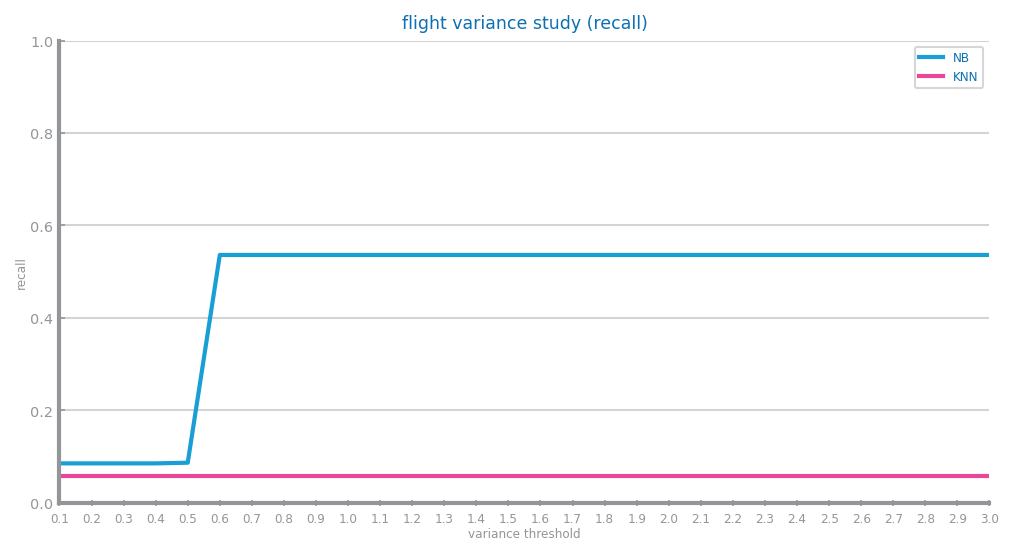

In [5]:
# Threshold analysis
figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train_data,
    test_data,
    target=target,
    max_threshold=3,
    lag=0.1,
    metric=metric,
    file_tag=file_tag,
)
# savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
show()

### Method 2: Redundant variables

In [19]:
# Local copy of select_redundant_variables with fixes
def select_redundant_variables(data: DataFrame, min_threshold: float = 0.90, target: str = "class") -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True, errors='ignore')
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop

In [32]:
# Identify redundant variables
vars2drop: list[str] = select_redundant_variables(train_data, target=target, min_threshold=0.5)
print("Variables to drop", vars2drop)

print(len(vars2drop), "variables to drop due to redundancy")

# Print final variable list with for loop
final_vars = [col for col in train_data.columns if col not in vars2drop + [target]]
print("Final variables:")
for var in final_vars:
    print(var)

Variables to drop ['IATA_Code_Operating_Airline_ZW', 'Operating_Airline_ZW', 'IATA_Code_Marketing_Airline_AS', 'IATA_Code_Operating_Airline_AS', 'Marketing_Airline_Network_AS', 'Operated_or_Branded_Code_Share_Partners_AS', 'Operating_Airline_AS', 'IATA_Code_Marketing_Airline_G4', 'IATA_Code_Operating_Airline_G4', 'Marketing_Airline_Network_G4', 'Operated_or_Branded_Code_Share_Partners_G4', 'Operating_Airline_G4', 'IATA_Code_Marketing_Airline_AA', 'IATA_Code_Operating_Airline_AA', 'Marketing_Airline_Network_AA', 'Operated_or_Branded_Code_Share_Partners_AA', 'Operating_Airline_AA', 'IATA_Code_Operating_Airline_PT', 'Operating_Airline_PT', 'IATA_Code_Operating_Airline_OH', 'Operating_Airline_OH', 'IATA_Code_Operating_Airline_C5', 'Operating_Airline_C5', 'IATA_Code_Marketing_Airline_DL', 'IATA_Code_Operating_Airline_DL', 'Marketing_Airline_Network_DL', 'Operated_or_Branded_Code_Share_Partners_DL', 'Operating_Airline_DL', 'IATA_Code_Operating_Airline_9E', 'Operated_or_Branded_Code_Share_Par

In [27]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [round(min_threshold + i * lag, 3) for i in range(ceil((1 - min_threshold) / lag) + 1)]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True, errors="ignore")
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(train_copy, test_copy, target=target, metric=metric)
        print(eval)
        if eval is not None and metric in eval:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    return results

Couldn't run MultinomialNB
{}
{'accuracy': 0.9497333333333333, 'recall': 0.05747126436781609, 'precision': 0.04484304932735426, 'auc': 0.5141983676466435, 'f1': 0.05037783375314862, 'confusion_matrix': array([[28452,   852],
       [  656,    40]])}
{}
Couldn't run MultinomialNB
{}
{'accuracy': 0.9497333333333333, 'recall': 0.05747126436781609, 'precision': 0.04484304932735426, 'auc': 0.5141983676466435, 'f1': 0.05037783375314862, 'confusion_matrix': array([[28452,   852],
       [  656,    40]])}
{}
Couldn't run MultinomialNB
{}
{'accuracy': 0.9497333333333333, 'recall': 0.05747126436781609, 'precision': 0.04484304932735426, 'auc': 0.5141983676466435, 'f1': 0.05037783375314862, 'confusion_matrix': array([[28452,   852],
       [  656,    40]])}
{}
Couldn't run MultinomialNB
{}
{'accuracy': 0.9497333333333333, 'recall': 0.05747126436781609, 'precision': 0.04484304932735426, 'auc': 0.5141983676466435, 'f1': 0.05037783375314862, 'confusion_matrix': array([[28452,   852],
       [  656,  

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

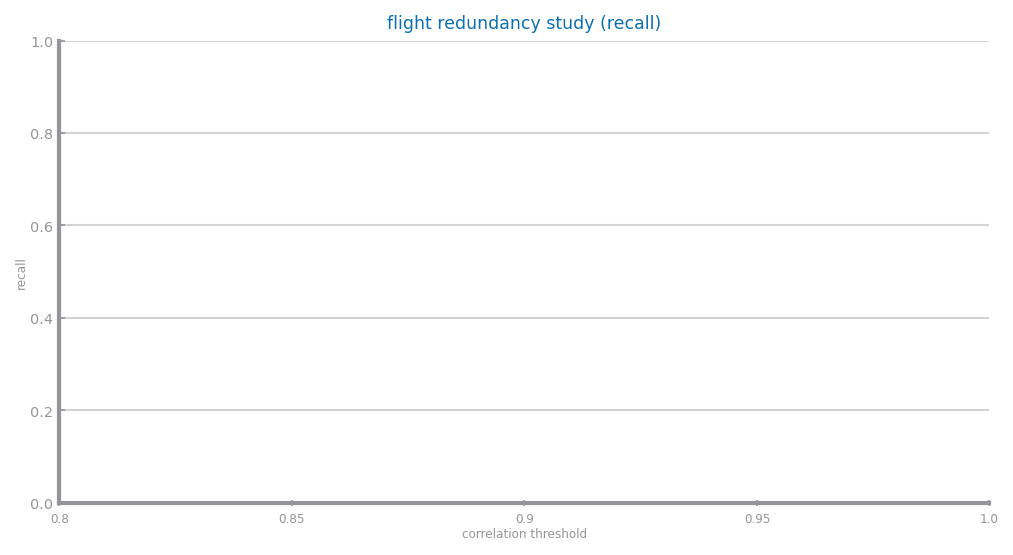

In [28]:
# Threshold analysis
figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train_data,
    test_data,
    target=target,
    min_threshold=0.8,
    lag=0.05,
    metric=metric,
    file_tag=file_tag,
)
# savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
show()

## Apply feature selection

In [35]:
# Local copy of apply_feature_selection without CSV saving
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    return train_copy, test_copy

### Low variance selection

In [ ]:
# Save copies of train/test after removing low variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.6, target=target)
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_lv.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_lv.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

### Redundant variable selection

In [ ]:
# Save copies of train/test after removing low variance variables
vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.6, target=target)
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_red.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_red.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

### Apply both

In [36]:
# Save copies of train/test after removing low variance variables
lv_vars2drop: list[str] = select_low_variance_variables(train_data, max_threshold=0.6, target=target)
red_vars2drop: list[str] = select_redundant_variables(train_data, min_threshold=0.5, target=target)

# Concatinate and remove duplicates
vars2drop: list[str] = list(set(lv_vars2drop + red_vars2drop))
train_cp, test_cp = apply_feature_selection(train_data, test_data, vars2drop)

# Re-add FlightDate
train_flightdate = input_train_data["FlightDate"]
test_flightdate  = input_test_data["FlightDate"]
train_cp["FlightDate"] = train_flightdate.values
test_cp["FlightDate"] = test_flightdate.values

output_train_path = "../../data/prepared/feature-selection/flight_train_fs_both.csv"
output_test_path  = "../../data/prepared/feature-selection/flight_test_fs_both.csv"

print("Saving feature selected TRAIN to:", output_train_path)
print("Saving feature selected TEST  to:", output_test_path)

train_cp.to_csv(output_train_path, index=False)
test_cp.to_csv(output_test_path,  index=False)


print(f"Original data: train={train_data.shape}, test={test_data.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Saving feature selected TRAIN to: ../../data/prepared/feature-selection/flight_train_fs_both.csv
Saving feature selected TEST  to: ../../data/prepared/feature-selection/flight_test_fs_both.csv
Original data: train=(70000, 181), test=(30000, 181)
After low variance FS: train_cp=(70000, 50), test_cp=(30000, 50)
